# Bird Classification - Final Project

### BERT fine-tuning for document classification

In [1]:
!pip install transformers torch

In [1]:
import os
import re
import numpy as np 
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel

import torch
from torch import cuda
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
device = 'cuda' if cuda.is_available() else 'cpu'

device

'cpu'

### Prepare the data
since the target is the names we will split the data by bird names (y) and the rest of the features (X)

In [2]:
import pandas as pd
# Read the TXT file into a DataFrame
df = pd.read_csv("Bird_Data.txt", delimiter=",", header=0)  # Adjust the delimiter based on your file format

df.rename(columns={ #rename the columns to be more consice
    "Frequency %": "Frequency",
    "Size (Max) in": "Size",
    "Weight (Max) g": "Weight"
}, inplace=True)

df.fillna("Unknown", inplace=True)  # Replace NaN with 'Unknown'
#df.dropna(inplace=True) #drop rows with missing data

# Assign X and Y values
X = df[['Frequency', 'Colors', 'Size', 'Weight', 'Genus', 'Family', 'Description']]  # Feature columns
y = df['Names']  # Target column

# Optionally save the X and Y values into separate files
X.to_csv("X_values.csv", index=False)
y.to_csv("Y_values.csv", index=False)

In [3]:
len(X), len(y)

(99, 99)

In [4]:
#for validation testing
prompt = pd.read_csv("prompt_eng.csv", header=0)
X_prompt = prompt['sentence_description']         # descriptions to feed into model
Y_prompt = prompt['desired_bird']                  # actual correct bird name
#test_y_prompt = np.array(X_prompt)

### An easy train/test split

In [5]:
# Beth - 4/15/25: Proposing we update split to something more like 70 to 30, I think the previous
# method it was overlapping since output was (90, 90, 89, 89)

# Beth's Proposed Code:
train_X = X[:70]
train_y = np.array(y[:70])
test_X = X[70:] # Captures 29%
test_y = np.array(y[70:]) # Captures 29%

len(train_X), len(train_y), len(test_X), len(test_y)

#Output: (70, 70, 29, 29) ensures no overlapping


(70, 70, 29, 29)

In [6]:
# not needed for training or evaluation, but useful for mapping examples
labels = {
    0:'Names',
    1:'Frequency',
    2:'Colors',
    3:'Size',
    4:'Weight',
    5:'Genus',
    6:'Family',
    7:'Description'
}

len(labels)

8

### Fine-tune BERT on the dataset

*Project language fine-tuning*

*loss function needs to change* 

*num-out needs to change*

*Not a binary task so this means we will need to use something like cross enropy - torch uses index values*

*try to get around 80% on the test set*

## Torch Data Set

In [7]:
class MultiLabelDataset(torch.utils.data.Dataset):

    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.targets = torch.tensor(labels, dtype=torch.long)
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            padding = 'max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets' : self.targets[index]
            #.clone().detach()
            #'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

## Bert Class
- first "layer" is a pre-trained BERT model
- you can add whatever layers you want after that

In [8]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()

        # Get the Bert Model that is pretrained
        # self.l1 = BertModel.from_pretrained("bert-base-uncased")#bert-base-uncased and BertModel
        self.l1 = BertModel.from_pretrained("prajjwal1/bert-mini")

        #Pass through the classifier we designed
        self.pre_classifier = torch.nn.Linear(self.l1.config.hidden_size, 256)#768
        self.classifier = torch.nn.Linear(256, NUM_OUT)#768 or 196
        self.dropout = torch.nn.Dropout(0.5)

        # Apply softmax activation
        self.softmax = torch.nn.Softmax(dim=1)

    
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        # Beth Fix: 4/21/25 - Need to reduce pooler batch size
        reduced_pooler = self.pre_classifier(pooler)
        output = self.classifier(reduced_pooler)
        # output = self.classifier(pooler)
        output = self.softmax(output) # Beth - Should not be used with CrossEntropyloss
        return output

## Helpful functions:
### Loss
- This task is binary, so it uses binary crossentropy loss
- Tasks with more labels will use categorical crossentropy
- Tasks that don't have labels, but rather have distributions should use KL divergence
- Tasks that don't have distributions should use something like RMSE loss
### Train
- Steps through the data batch by batch
- grabs ids, masks, and token_type_ids which are required inputs for BERT
- inputs are passed through the model, compared to targets, computes loss function, backprops
### Validation
- Takes a model, passes inputs
- Need to use the targets from here because they are potentially shuffled!

In [9]:
# Loss Function - Uses Categorical Cross Entropy instead of Binary Entropy
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

# Train Function - Step through data batch by batch
def train(model, training_loader, optimizer):
    model.train()
    
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad() # Beth: Removing duplicate
        loss.backward()
        optimizer.step()
    return loss

# Validation Function - Take Model Pass Inputs
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask, token_type_ids)
            #outputs = torch.sigmoid(outputs).cpu().detach()
            outputs = torch.argmax(outputs, dim=1).cpu().detach()
            fin_outputs.extend(outputs.tolist())
            fin_targets.extend(targets.tolist())
    return torch.tensor(fin_outputs), torch.tensor(fin_targets)

# Gets top 3 results Function - Take Model Pass Inputs
def validation_top3(model, testing_loader, le):
    model.eval()  # Ensure model is in evaluation mode
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():  # No gradients needed for validation
        for data in tqdm(testing_loader):
            targets = data['targets']  # True labels (bird names or IDs)
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        
            outputs = model(ids, mask, token_type_ids)  # Model's outputs (batch_size, num_classes)

            # Get top 3 predictions for each sample
            top3_vals, top3_indices = torch.topk(outputs, k=3, dim=1)  # (batch_size, 3)

            # Map top 3 indices to bird names using label encoder
            top3_names_batch = []
            for indices in top3_indices.cpu().numpy():  # Iterate over each item in the batch
                names = le.inverse_transform(indices)  # Convert indices to bird names
                top3_names_batch.append(names.tolist())  # Store as a list of 3 names

            fin_outputs.extend(top3_names_batch)  # Add the top 3 predictions
            fin_targets.extend(targets.tolist())  # Add the ground truth targets

    return fin_outputs, fin_targets

## The Tokenizer:

In [ ]:
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-mini')

#Beth - 4/15/25: Convert train to proper data type:
desc_list = train_X["Description"].tolist()

#Beth - 4/21/25: Trying a different method to encode since we use desc_list so need batch
tokenizer.batch_encode_plus(
            desc_list, # Beth 4/15/25: replaced train_X[5] with the list version (DF was erroring)
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'              
        )

{'input_ids': tensor([[  101,  4242,   102,  ...,     0,     0,     0],
        [  101,  3609,   102,  ...,     0,     0,     0],
        [  101,  2227,  1010,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  5810,  ...,     0,     0,     0],
        [  101,  1037,  2235,  ...,     0,     0,     0],
        [  101,  1037, 20640,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

## Training Setup 

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(np.concatenate([train_y, test_y]))

train_y_encoded = le.transform(train_y)
test_y_encoded = le.transform(test_y)

train_y_tensor = torch.from_numpy(train_y_encoded).long()
test_y_tensor = torch.from_numpy(test_y_encoded).long()

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 10  #5.88% for 10 and 50 epochs
# Beth Propoal: Shouldn't this be 8?
# NUM_OUT = 7 # binary task - 2

# Beth - 4/23/25: Trying this instead, may need to focus on the actual bird names
NUM_OUT = len(le.classes_)
LEARNING_RATE = 2e-05 #2e-05 standard gave 5.88% with 10/50 epoch

train_desc_list = train_X["Description"].tolist()
test_desc_list = test_X["Description"].tolist()

training_data = MultiLabelDataset(train_desc_list, train_y_tensor, tokenizer, MAX_LEN)
test_data = MultiLabelDataset(test_desc_list, test_y_tensor, tokenizer, MAX_LEN)


train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)

/tmp/ipykernel_29361/1357419957.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(labels, dtype=torch.long)


## Train and Evaluate 

In [45]:
#Beth Proposal: When time allows, maybe we should setup something to save our epoch progress

model = BERTClass(NUM_OUT)
model.to(device)    

optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
    guesses = guess
    targets = targs
    torch.save(model.state_dict(), './model.pt')
    print('arracy on test set {}'.format(accuracy_score(guesses.numpy(), targets.numpy())))#.indices
    # print(f'Accuracy on test set: {accuracy_score(guess.cpu().numpy(), targs.cpu().numpy())}') # Beth

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 0, Loss:  4.594884395599365


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1, Loss:  4.592948913574219


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2, Loss:  4.594738483428955


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3, Loss:  4.592576026916504


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4, Loss:  4.592197895050049


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5, Loss:  4.594428062438965


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6, Loss:  4.591325759887695


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7, Loss:  4.590301990509033


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 8, Loss:  4.584939002990723


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9, Loss:  4.586690425872803


  0%|          | 0/4 [00:00<?, ?it/s]

arracy on test set 0.0


## Bird sentences into our model

In [ ]:
test_prompt_encoded = le.transform(Y_prompt)
test_prompt_tensor = torch.from_numpy(test_prompt_encoded).long()
test_data_prompt = MultiLabelDataset(X_prompt, test_prompt_tensor, tokenizer, MAX_LEN)
testing_prompt_loader = torch.utils.data.DataLoader(test_data_prompt, **test_params)

#new test
results = validation_top3(model, testing_prompt_loader, le)
print(results)
prompt["bird_model"] = [str(names) for names in results[0]] 
prompt.to_csv("prompt_eng.csv", index=False)

# Define a scoring function
def score_match(row):
    try:
        index = row['bird_model'].index(row['desired_bird']) 
        prompt['bird_model'] = results[0]
        return 3 - index  # index 0 = 3 points, index 1 = 2, index 2 = 1
    except ValueError:
        return 0  # not in list

prompt['score'] = prompt.apply(score_match, axis=1)

# Calculate accuracy based on score == 3
accuracy = (prompt['score'] == 3).mean()

# Print results
print(prompt['score'])
print(f"\nAccuracy (score == 3): {accuracy:.2%}")

/tmp/ipykernel_29361/1357419957.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(labels, dtype=torch.long)


  0%|          | 0/3 [00:00<?, ?it/s]

([['Pileated Woodpecker', 'Western Bluebird', 'California Quail'], ['Western Bluebird', 'Red-breasted Nuthatch', 'Tree Swallow'], ['Bald Eagle', 'Tree Swallow', 'Brown Creeper'], ['Tree Swallow', 'Bald Eagle', "Swainson's hawk"], ['Western Bluebird', "Swainson's hawk", 'Bald Eagle'], ['Tree Swallow', "Swainson's hawk", 'Turkey Vulture'], ['Bald Eagle', 'Belted Kingfisher', 'Western Bluebird'], ["Swainson's hawk", 'Tree Swallow', 'Bald Eagle'], ['Bald Eagle', 'Eurasian Collared-Dove', "Swainson's hawk"], ['Tree Swallow', "Swainson's hawk", 'Bald Eagle'], ['Pileated Woodpecker', "Swainson's hawk", 'Bald Eagle'], ['Yellow Warbler', 'Pileated Woodpecker', 'House finch'], ['Bald Eagle', 'Tree Swallow', 'Western Grebe'], ['Bald Eagle', 'Dark-eyed Junco', 'Tree Swallow'], ["Swainson's hawk", 'Tree Swallow', 'Pileated Woodpecker'], ['Western Bluebird', 'Belted Kingfisher', 'Bald Eagle'], ['Bald Eagle', 'Tree Swallow', 'Brown Creeper']], [75, 45, 87, 71, 88, 37, 70, 49, 22, 8, 55, 59, 95, 84, 5

In [ ]:
#  Beth Version of Getting Accuracy Score test
import ast

def validation_top3_vers2(model, testing_loader, le):
    model.eval()
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)

            outputs = model(ids, mask, token_type_ids)

            top3_vals, top3_indices = torch.topk(outputs, k=3, dim=1)

            top3_names_batch = []
            for indices in top3_indices.cpu().numpy():
                names = [le.classes_[i] for i in indices]
                top3_names_batch.append(names)

            fin_outputs.extend(top3_names_batch)
            fin_targets.extend(targets.tolist())

    return fin_outputs, fin_targets
 

test_prompt_encoded = le.transform(Y_prompt)
test_prompt_tensor = torch.from_numpy(test_prompt_encoded).long()
test_data_prompt = MultiLabelDataset(X_prompt, test_prompt_tensor, tokenizer, MAX_LEN)
testing_prompt_loader = torch.utils.data.DataLoader(test_data_prompt, **test_params)

#new test
results = validation_top3(model, testing_prompt_loader, le)
print(results)
# Convert string representation of lists into real Python lists
prompt['bird_model'] = results[0]  # results[0] contains top-3 predictions
prompt.to_csv("prompt_eng.csv", index=False)

# Define a scoring function
def score_match(row):
    try:
        index = row['bird_model'].index(row['desired_bird'])
        return 3 - index  # index 0 = 3 points, index 1 = 2, index 2 = 1
    except ValueError:
        return 0  # not in list

prompt['score'] = prompt.apply(score_match, axis=1)

#for our bird classifier model
prompt['top1_prediction'] = prompt['bird_model'].apply(lambda x: x[0])
prompt['in_top3'] = prompt.apply(lambda row: row['desired_bird'] in row['bird_model'], axis=1)
prompt['match_rank'] = prompt.apply(lambda row: row['bird_model'].index(row['desired_bird']) + 1 if row['desired_bird'] in row['bird_model'] else None, axis=1)

print(prompt[['desired_bird', 'bird_model', 'top1_prediction', 'match_rank', 'score']])

# Calculate accuracy based on score == 3
accuracy_bm = (prompt['score'] == 3).mean()

print(f"Top-1 Accuracy: {accuracy_bm:.2%}")

# Also show top-3 accuracy
top3_accuracy_bm = prompt['in_top3'].mean()
print(f"Top-3 Accuracy: {top3_accuracy_bm:.2%}")
    

/tmp/ipykernel_29361/1357419957.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(labels, dtype=torch.long)


  0%|          | 0/3 [00:00<?, ?it/s]

([['Bald Eagle', 'Eurasian Collared-Dove', "Swainson's hawk"], ['Bald Eagle', 'Dark-eyed Junco', 'Tree Swallow'], ['Bald Eagle', 'Belted Kingfisher', 'Western Bluebird'], ["Swainson's hawk", 'Tree Swallow', 'Pileated Woodpecker'], ['Tree Swallow', 'Bald Eagle', "Swainson's hawk"], ['Bald Eagle', 'Tree Swallow', 'Brown Creeper'], ['Bald Eagle', 'Tree Swallow', 'Western Grebe'], ['Western Bluebird', 'Red-breasted Nuthatch', 'Tree Swallow'], ['Pileated Woodpecker', 'Western Bluebird', 'California Quail'], ['Yellow Warbler', 'Pileated Woodpecker', 'House finch'], ['Pileated Woodpecker', "Swainson's hawk", 'Bald Eagle'], ['Bald Eagle', 'Tree Swallow', 'Brown Creeper'], ['Tree Swallow', "Swainson's hawk", 'Bald Eagle'], ['Western Bluebird', 'Belted Kingfisher', 'Bald Eagle'], ["Swainson's hawk", 'Tree Swallow', 'Bald Eagle'], ['Tree Swallow', "Swainson's hawk", 'Turkey Vulture'], ['Western Bluebird', "Swainson's hawk", 'Bald Eagle']], [22, 84, 70, 5, 71, 53, 95, 45, 75, 59, 55, 87, 8, 19, 49

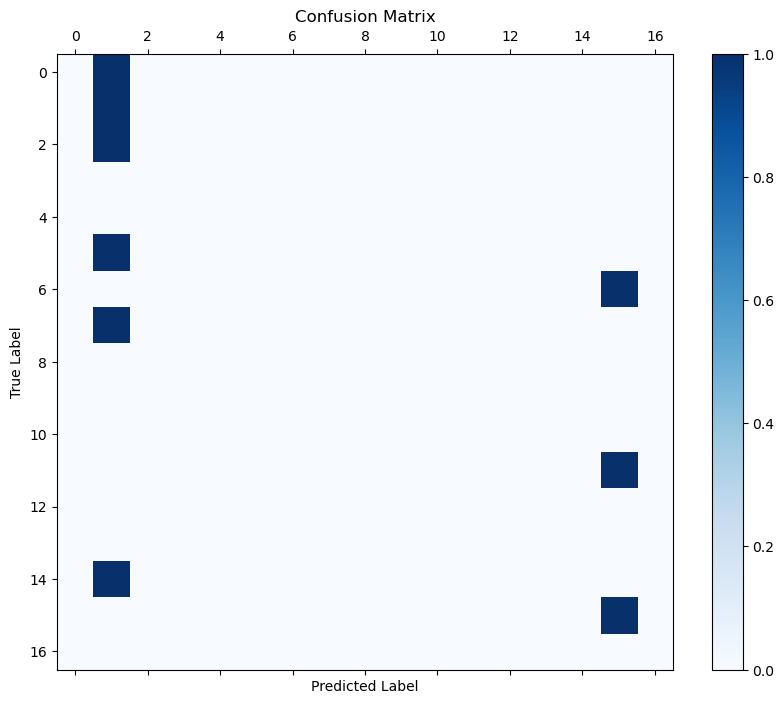

In [49]:
#confusion matrix 
from sklearn.metrics import confusion_matrix
#import seaborn as sns
import matplotlib.pyplot as plt
#get unique tags in sorted order
tags = sorted(set(prompt['desired_bird']))

confusion = confusion_matrix(prompt['desired_bird'], prompt['top1_prediction'], labels=tags)

#ploting the confusion matrix
fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(confusion, cmap="Blues")
plt.colorbar(cax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [63]:
#get the gemini accuracy
total_score = 0
max_score = len(prompt) * 3
num_rows = 0


for index, row in prompt.iterrows():
    desired_bird = row['desired_bird'].strip().lower()
    predictions_raw = row['gemini_2.0_flash']
    predictions = [p.strip().lower() for p in predictions_raw.split(',')]

    score = 0
    if len(predictions) >= 1 and desired_bird == predictions[0]:
        score = 3
    elif len(predictions) >= 2 and desired_bird == predictions[1]:
        score = 2 
    elif len(predictions) >= 3 and desired_bird == predictions[2]:
        score = 1
    else:
        score = 0

    total_score += score
    max_score += 3
    num_rows += 1
    print(f"Row {num_rows}: desired_bird = {desired_bird}, prediction = {predictions}, score = {score}")
    
accuracy = total_score / max_score if max_score > 0  else 0
accuracy = accuracy * 100
print(f"\nTotal Score: {total_score}")
print(f"Max Score: {max_score}")
print(f"Accuracy: {accuracy:2f}")

Row 1: desired_bird = american robin, prediction = ['american robin', 'red-winged blackbird', 'house finch'], score = 3
Row 2: desired_bird = bald eagle, prediction = ['bald eagle', 'golden eagle', 'california condor'], score = 3
Row 3: desired_bird = buteos, prediction = ['red-tailed hawk', 'ferruginous hawk', 'northern harrier'], score = 0
Row 4: desired_bird = prairie falcon, prediction = ['sharp-shinned hawk', "cooper's hawk", 'american kestrel'], score = 0
Row 5: desired_bird = mourning dove, prediction = ['mourning dove', 'rock pigeon', 'eurasian collared-dove'], score = 3
Row 6: desired_bird = house finch, prediction = ['house finch', "cassin's finch", 'purple finch'], score = 3
Row 7: desired_bird = turkey vulture, prediction = ['turkey vulture', 'golden eagle', 'california condor'], score = 3
Row 8: desired_bird = western bluebird, prediction = ['western bluebird', 'mountain bluebird', 'lazuli bunting'], score = 3
Row 9: desired_bird = fox sparrow, prediction = ['common redpol